In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 9.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d03148709f4a86feaebe0b97d3fe9d0cfdec6747620f2c44d2460fd553d13413
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


###ABOUT DATASET
This dataset details the 5-star rating given by the movie recommendation service MovieLens. 25,000,095 ratings for 62423 films are included. 162,541 users between January 9, 1995, and November 21, 2019, produced this data. Creating this dataset took place on November 21, 2019. Users who wanted to be included were chosen at random. Each chosen user had given at least 20 films a rating. There is no demographic data provided. There is no other data provided; each user is represented by an id. The files "movies.csv" and "ratings.csv" have the data.
The following URL provides the data: https://grouplens.org/datasets/movielens/25m

In [ ]:
%cd /content/drive/MyDrive/Big_Data_Assignment/Movie_Recommender/ml-25m

/content/drive/MyDrive/Big_Data_Assignment/Movie_Recommender/ml-25m


In [ ]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import csv
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [ ]:
spark = SparkSession.builder.master('local[*]').appName('movie').getOrCreate()

Ratings Data File Structure

In [ ]:
rating = pd.read_csv('/content/drive/MyDrive/Big_Data_Assignment/Movie_Recommender/ml-25m/ratings.csv')
rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
rating = rating.apply(pd.to_numeric)

Convert to float type

In [ ]:
rating['rating'] = rating['rating'].astype(float)

In [ ]:
rating.count()

userId       25000095
movieId      25000095
rating       25000095
timestamp    25000095
dtype: int64

Taking sample from this huge dataset: Considering only 5 review per person, as this ALS theorem will take lot of time to process

In [ ]:
rating= rating.groupby('userId').head(5)

In [ ]:
rating.count()

userId       812705
movieId      812705
rating       812705
timestamp    812705
dtype: int64

In [ ]:
rating.nunique()

userId       162541
movieId        3658
rating           10
timestamp    774003
dtype: int64

Movies Data File Structure

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/Big_Data_Assignment/Movie_Recommender/ml-25m/movies.csv')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.count()

movieId    62423
title      62423
genres     62423
dtype: int64

Join ratings and movies tables(Left join)

In [ ]:
data = pd.merge(rating, movies, on='movieId', how='left')
data.count()

userId       812705
movieId      812705
rating       812705
timestamp    812705
title        812705
genres       812705
dtype: int64

In [ ]:
datafiltered = data[(data.userId == 471)]
datafiltered.head(10)

,userId,movieId,rating,timestamp,title,genres
2350,471,318,4.0,1499822567,"Shawshank Redemption, The (1994)",Crime|Drama
2351,471,356,4.5,1499822674,Forrest Gump (1994),Comedy|Drama|Romance|War
2352,471,1721,4.0,1500418562,Titanic (1997),Drama|Romance
2353,471,1784,3.5,1500418530,As Good as It Gets (1997),Comedy|Drama|Romance
2354,471,2028,4.0,1500417495,Saving Private Ryan (1998),Action|Drama|War


Taking sample from this dataset: Considering 1000 users

In [ ]:
df = data[data['userId'].between(0,1000)]

In [ ]:
df.count()

userId       5000
movieId      5000
rating       5000
timestamp    5000
title        5000
genres       5000
dtype: int64

EDA

In [ ]:
def substringbeforepipe(value):
  return value.split('|')[0]

In [ ]:
df['genres'] = df.apply(lambda x: substringbeforepipe(x.genres), axis=1)
df.head()

<ipython-input-21-aa71757f2c8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres'] = df.apply(lambda x: substringbeforepipe(x.genres), axis=1)


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy


Top 10 most rated movies

In [ ]:
top_rated = df.groupby('title').size().sort_values(ascending=False)[:10]
top_rated

title
Toy Story (1995)                             340
Usual Suspects, The (1995)                   172
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)    171
GoldenEye (1995)                             158
Seven (a.k.a. Se7en) (1995)                  156
Braveheart (1995)                            153
Heat (1995)                                  150
Star Wars: Episode IV - A New Hope (1977)    137
Shawshank Redemption, The (1994)             132
Jumanji (1995)                               124
dtype: int64

Top 10 movie genres

In [ ]:
top_genre = df.groupby('genres').size().sort_values(ascending = False)[:10]
top_genre

genres
Action         1219
Comedy         1211
Adventure       734
Drama           653
Crime           612
Mystery         334
Children        145
Animation        40
Documentary      20
Horror           12
dtype: int64

Unique genres available in dataset

In [ ]:
unique_genre = pd.DataFrame(df.genres.str.split('|').tolist()).stack().unique()
unique_genre = pd.DataFrame(unique_genre, columns=['genre'])
print(unique_genre)

          genre
0        Comedy
1         Drama
2     Adventure
3        Action
4       Mystery
5         Crime
6      Children
7     Animation
8   Documentary
9      Thriller
10       Horror
11      Western
12       Sci-Fi
13      Romance
14      Fantasy
15      Musical


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2707975eb0>]],
      dtype=object)

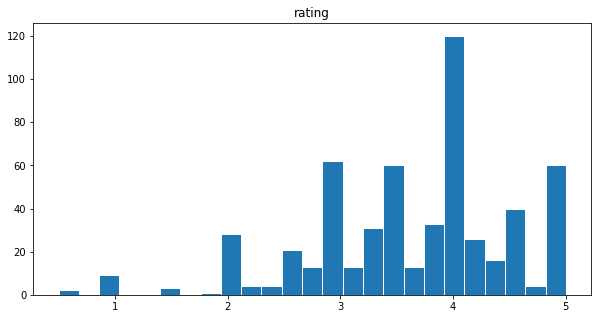

In [ ]:
df1 = df[['movieId','rating']].groupby('movieId').mean()
df1.hist(bins=25, grid=False, edgecolor='w', label='All genres', figsize=(10,5))

In [ ]:
rate = spark.createDataFrame(df)
print(rate.count())

5000


In [ ]:
df_naremoved = rate.na.drop()
df_naremoved.show()

+------+-------+------+----------+--------------------+---------+
|userId|movieId|rating| timestamp|               title|   genres|
+------+-------+------+----------+--------------------+---------+
|     1|    296|   5.0|1147880044| Pulp Fiction (1994)|   Comedy|
|     1|    306|   3.5|1147868817|Three Colors: Red...|    Drama|
|     1|    307|   5.0|1147868828|Three Colors: Blu...|    Drama|
|     1|    665|   5.0|1147878820|  Underground (1995)|   Comedy|
|     1|    899|   3.5|1147868510|Singin' in the Ra...|   Comedy|
|     2|      1|   3.5|1141415820|    Toy Story (1995)|Adventure|
|     2|     62|   0.5|1141417130|Mr. Holland's Opu...|    Drama|
|     2|    110|   5.0|1141416589|   Braveheart (1995)|   Action|
|     2|    150|   4.0|1141415790|    Apollo 13 (1995)|Adventure|
|     2|    151|   4.5|1141415643|      Rob Roy (1995)|   Action|
|     3|      1|   4.0|1439472215|    Toy Story (1995)|Adventure|
|     3|     29|   4.5|1484754967|City of Lost Chil...|Adventure|
|     3|  

Removing timestamp

In [ ]:
df_naremoved = df_naremoved.drop(df_naremoved.timestamp)
df_naremoved.show()

+------+-------+------+--------------------+---------+
|userId|movieId|rating|               title|   genres|
+------+-------+------+--------------------+---------+
|     1|    296|   5.0| Pulp Fiction (1994)|   Comedy|
|     1|    306|   3.5|Three Colors: Red...|    Drama|
|     1|    307|   5.0|Three Colors: Blu...|    Drama|
|     1|    665|   5.0|  Underground (1995)|   Comedy|
|     1|    899|   3.5|Singin' in the Ra...|   Comedy|
|     2|      1|   3.5|    Toy Story (1995)|Adventure|
|     2|     62|   0.5|Mr. Holland's Opu...|    Drama|
|     2|    110|   5.0|   Braveheart (1995)|   Action|
|     2|    150|   4.0|    Apollo 13 (1995)|Adventure|
|     2|    151|   4.5|      Rob Roy (1995)|   Action|
|     3|      1|   4.0|    Toy Story (1995)|Adventure|
|     3|     29|   4.5|City of Lost Chil...|Adventure|
|     3|     32|   4.5|Twelve Monkeys (a...|  Mystery|
|     3|     50|   5.0|Usual Suspects, T...|    Crime|
|     3|    111|   4.0|  Taxi Driver (1976)|    Crime|
|     4|  

In [ ]:
df_final = df_naremoved

Collaborative Filtering

In [ ]:
from pyspark.sql.functions import col
df_cf = df_final.select(col("userId"),col("movieId"),col("rating"))

In [ ]:
df_cf.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    296|   5.0|
|     1|    306|   3.5|
|     1|    307|   5.0|
|     1|    665|   5.0|
|     1|    899|   3.5|
|     2|      1|   3.5|
|     2|     62|   0.5|
|     2|    110|   5.0|
|     2|    150|   4.0|
|     2|    151|   4.5|
|     3|      1|   4.0|
|     3|     29|   4.5|
|     3|     32|   4.5|
|     3|     50|   5.0|
|     3|    111|   4.0|
|     4|      1|   3.0|
|     4|    260|   3.5|
|     4|    296|   4.0|
|     4|    541|   4.5|
|     4|    589|   4.0|
+------+-------+------+
only showing top 20 rows



Recommender System by User Ratings: Data Split(80-20)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.mllib.recommendation import MatrixFactorizationModel
from pyspark.mllib.recommendation import Rating

In [ ]:
df_cf.printSchema()

In [ ]:
(train, test) = df_cf.randomSplit([0.8,0.2], seed = 1234)

ALS

In [ ]:
als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop', nonnegative=True, implicitPrefs=False)

**Hyperparameters:** 

**rank** is the number of latent factors in the model (default value is 10, but we have used multiple value to obtain the optimal one).

**regParam** specifies the regularization parameter in ALS (default value is 1.0, but we have used multiple value to obtain the optimal one).


In [ ]:
param_grid = ParamGridBuilder().addGrid(als.rank, [10,50,100,150]).addGrid(als.regParam, [.01, .05, .1, .15, 1.0]).build()

In [ ]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [ ]:
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

In [ ]:
model = cv.fit(train)

In [ ]:
best_model = model.bestModel

In [ ]:
prediction = best_model.transform(test)
rmse = evaluator.evaluate(prediction)

In [ ]:
print("RMSE = " + str(rmse))
print(best_model.rank)
print(best_model._java_obj.parent().getMaxIter())
print(best_model._java_obj.parent().getRegParam())

RMSE = 1.1993463760561627
150
10
0.05


In [ ]:
print("MSE = "+str(rmse*rmse))

MSE = 1.4384317297590503


Generating 10 recommendations for all users

In [ ]:
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{1208, 5.3587494...|
|     3|[{83, 5.7006803},...|
|     5|[{82, 5.957314}, ...|
|     6|[{802, 5.19449}, ...|
|     9|[{104, 5.351904},...|
|    12|[{1968, 4.5772767...|
|    13|[{83, 5.398841}, ...|
|    15|[{1208, 5.802679}...|
|    16|[{83, 5.0395646},...|
|    17|[{5055, 3.9713926...|
|    19|[{802, 3.2073674}...|
|    20|[{1208, 5.3178296...|
|    22|[{802, 6.60013}, ...|
|    26|[{82, 5.4499207},...|
|    27|[{408, 4.9675117}...|
|    28|[{82, 6.348103}, ...|
|    31|[{446, 4.3113685}...|
|    34|[{1208, 4.414784}...|
|    35|[{802, 6.056931},...|
|    37|[{83, 5.9229903},...|
+------+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import explode, col, concat_ws

nrecommendations = nrecommendations.withColumn("rec_exp", explode("recommendations")).select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))
nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|     1|   1208|5.3587494|
|     1|     83|5.3242836|
|     1|     82|5.3242836|
|     1|    750|5.2772346|
|     1|   2070| 5.213187|
|     1|   2333| 5.213187|
|     1|    924|5.1368804|
|     1|   3578| 5.125418|
|     1|    154|5.1182213|
|     1|    307| 5.046453|
+------+-------+---------+



In [ ]:
nrecommendations_pd = nrecommendations.toPandas()

In [ ]:
nrecommendations_pd.head()

,userId,movieId,rating
0,1,1208,5.358749
1,1,83,5.324284
2,1,82,5.324284
3,1,750,5.277235
4,1,2070,5.213187


Merge with movies table to get the recommended movies title (Left join)

In [ ]:
results = pd.merge(nrecommendations_pd,movies,on='movieId',how='left')
results.head(5)

,userId,movieId,rating,title,genres
0,1,1208,5.358749,Apocalypse Now (1979),Action|Drama|War
1,1,83,5.324284,Once Upon a Time... When We Were Colored (1995),Drama|Romance
2,1,82,5.324284,Antonia's Line (Antonia) (1995),Comedy|Drama
3,1,750,5.277235,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
4,1,2070,5.213187,Tender Mercies (1983),Drama|Romance|Western


Movies recommended to User with ID = 471

In [ ]:
resultsFiltered = results[(results.userId == 471)]
resultsFiltered.head(10)

,userId,movieId,rating,title,genres
2290,471,1619,4.940444,Seven Years in Tibet (1997),Adventure|Drama|War
2291,471,802,4.779288,Phenomenon (1996),Drama|Romance
2292,471,83,4.753920,Once Upon a Time... When We Were Colored (1995),Drama|Romance
2293,471,82,4.753920,Antonia's Line (Antonia) (1995),Comedy|Drama
2294,471,1682,4.709680,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
2295,471,1704,4.571174,Good Will Hunting (1997),Drama|Romance
2296,471,1246,4.511040,Dead Poets Society (1989),Drama
2297,471,356,4.417212,Forrest Gump (1994),Comedy|Drama|Romance|War
2298,471,1208,4.412009,Apocalypse Now (1979),Action|Drama|War
2299,471,1584,4.380128,Contact (1997),Drama|Sci-Fi


In [ ]:
from pyspark.sql.functions import concat_ws, collect_list

df_result = nrecommendations.groupBy("userId").agg(concat_ws(",", collect_list(col("movieId"))))
df_result.show(5)

+------+-----------------------------------+
|userId|concat_ws(,, collect_list(movieId))|
+------+-----------------------------------+
|     1|               1208,83,82,750,20...|
|     3|               83,82,1619,802,20...|
|     5|               82,83,446,2070,23...|
|     6|               802,1619,82,83,52...|
|     9|               104,82,83,236,802...|
+------+-----------------------------------+
only showing top 5 rows



In [ ]:
df_result_table = df_result.withColumnRenamed("concat_ws(,, collect_list(movieId))","Top 10 recommendations")

In [ ]:
df_result_table.show()

+------+----------------------+
|userId|Top 10 recommendations|
+------+----------------------+
|     1|  1208,83,82,750,20...|
|     3|  83,82,1619,802,20...|
|     5|  82,83,446,2070,23...|
|     6|  802,1619,82,83,52...|
|     9|  104,82,83,236,802...|
|    12|  1968,446,2028,233...|
|    13|  83,82,2070,2333,8...|
|    15|  1208,750,924,83,8...|
|    16|  83,82,1240,1221,3...|
|    17|  5055,6942,2070,23...|
|    19|  802,83,82,1682,12...|
|    20|  1208,82,83,1193,2...|
|    22|  802,3578,1682,126...|
|    26|  82,83,1208,802,16...|
|    27|  408,802,178,1704,...|
|    28|  82,83,2333,2070,1...|
|    31|  446,2333,2070,83,...|
|    34|  1208,83,82,750,20...|
|    35|  802,3578,1682,83,...|
|    37|  83,82,802,2070,23...|
+------+----------------------+
only showing top 20 rows



In [ ]:
df_final_pd = df_result_table.toPandas()
df_final_pd.head()

,userId,Top 10 recommendations
0,1,"1208,83,82,750,2070,2333,924,3578,154,307"
1,3,"83,82,1619,802,2070,2333,446,1208,2028,1193"
2,5,"82,83,446,2070,2333,802,1619,3578,1208,750"
3,6,"802,1619,82,83,527,912,1704,1208,1584,3578"
4,9,"104,82,83,236,802,364,446,3578,253,1682"


Saprk df to csv -> output in text file

In [ ]:
df_final_pd.to_csv('/content/drive/MyDrive/Big_Data_Assignment/Movie_Recommender/Recommendations.txt', sep = '\t')